In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import pandas as pd
# from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats  
from scipy import signal as sg
from s3fs import S3FileSystem, S3Map
import scipy
from speccy import sick_tricks as gary
from scipy import stats
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
# mle function import
from IPython.display import display, HTML
import importlib
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [25, 10]
# np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

In [4]:
# Calculate the Coriolis frequency
# lat = ds.LATITUDE.values
# lon = ds.LONGITUDE.values
# f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
# f_coriolis_cpd = np.abs(f_coriolis*86400/(2*np.pi))
f_coriolis_cpd = 0.74
print('Coriolis frequency is',f_coriolis_cpd, 'cpd')
# print(lat,lon)
#Principal lunar semidiurnal
M2_freq = 0.0805*24 #cpd
M4_freq = 2*M2_freq
#Lunar elliptic semidiurnal
N2_freq = 0.0790*24 #cpd

#Princinpal lunar diurnal
O1_freq = 0.0387*24 #cpd

#Lunisolar diurnal
K1_freq = 0.0418*24 #cpd

#Principal solar semidiurnal
S2_freq = 0.0833*24 #cpd

xcoords = [f_coriolis_cpd, O1_freq, K1_freq,M2_freq,S2_freq]
xcoords_label = ['Coriolis_freq', 'K1', 'O1','M2','S2']
xcoords_color = ['orange', 'c', 'm','r','b','g']

Coriolis frequency is 0.74 cpd


# Synthetic Fit

In [6]:
from speccy import ut
from speccy import sample
from speccy import sick_tricks as gary

In [7]:
# # total depth is ~400m
interest_depth = 299
#y = Temp_profile.temperature.sel(depth=interest_depth ) #remove the depth avg velocity

n = 600000
delta = 600/86400
tt = ut.taus(n, delta)
sigma = 1e-6

## Matern

In [9]:
# from speccy import acf
def matern(dx, params,lmbda=3, sigma = 0, acf = True):
    """General Matern covariance a la Lilly/Sykulski"""

    eta = params[0]
    alpha = params[1]
#     lmbda = params[2]   # cpd

    lmbda = 2*np.pi*lmbda  #radius
    nu = alpha - 1/2
    
    K = 2 * np.power(eta, 2) / (gamma(nu) * np.power(2, nu))
    K *= np.power(np.abs(lmbda * dx), nu)
    K *= K_nu(nu, np.abs(lmbda * dx))
    K[np.isnan(K)] = np.power(eta, 2.)

    if acf:
        K[0] = K[0] + sigma**2
    else:
        n = dx.shape[0]
        K += sigma**2 * np.eye(n)
        
    return K
        
def matern_spectra(ff, params, lmbda=20):
    """General Matern PSD a la Lilly/Sykulski"""

    eta = params[0]
    alpha = params[1]
    #     lmbda = params[2]
    lmbda = 2*np.pi*lmbda
    c = (gamma(1 / 2) * gamma(alpha - 1 / 2)) / (2 * gamma(alpha) * np.pi)
    S = np.power(eta, 2) * np.power(lmbda, 2 * alpha - 1) / c
    S *= np.power(np.power(2 * np.pi * ff, 2) + np.power(lmbda, 2), -alpha)
    
    return S        

def Matern_PSD_1st_derivative_true(ff, params,lmbda=3):
    
    eta = params[0]
    alpha = params[1]
    
    return -alpha*(2*ff)/(np.power(ff,2)+np.power(lmbda,2))

In [10]:
#Testing
#when ω >> λ:
def Asymptote_Matern(ff, params,lmbda=3):
    eta = params[0]
    alpha = params[1]
    
    ff = 2*np.pi*ff
    lmbda = 2*np.pi*lmbda
    c = (gamma(1 / 2) * gamma(alpha - 1 / 2)) / (2 * gamma(alpha) * np.pi)
    S = np.power(eta, 2) * np.power(lmbda, 2 * alpha - 1) / c
    #when w >> λ:
    S *= np.power(np.power(ff, 2), -alpha)
    return S

#when ω >> ω_0:
#when ω >> ω_0+1/l_exp:
def Asymptote_LR(f, params):
    eta   = params[0]
    l_exp = params[1]   # day
    f = 2*np.pi*f
    c = 1/l_exp   # radius^-1
    return np.power(eta, 2.)*c*2/(f**2 )

C:\Users\21924032\AppData\Local\Temp\ipykernel_42184\466346793.py:14: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))
C:\Users\21924032\AppData\Local\Temp\ipykernel_42184\1815286008.py:12: RuntimeWarning: divide by zero encountered in power
  S *= np.power(np.power(ff, 2), -alpha)


the breaking point is at 1.5915494309189535


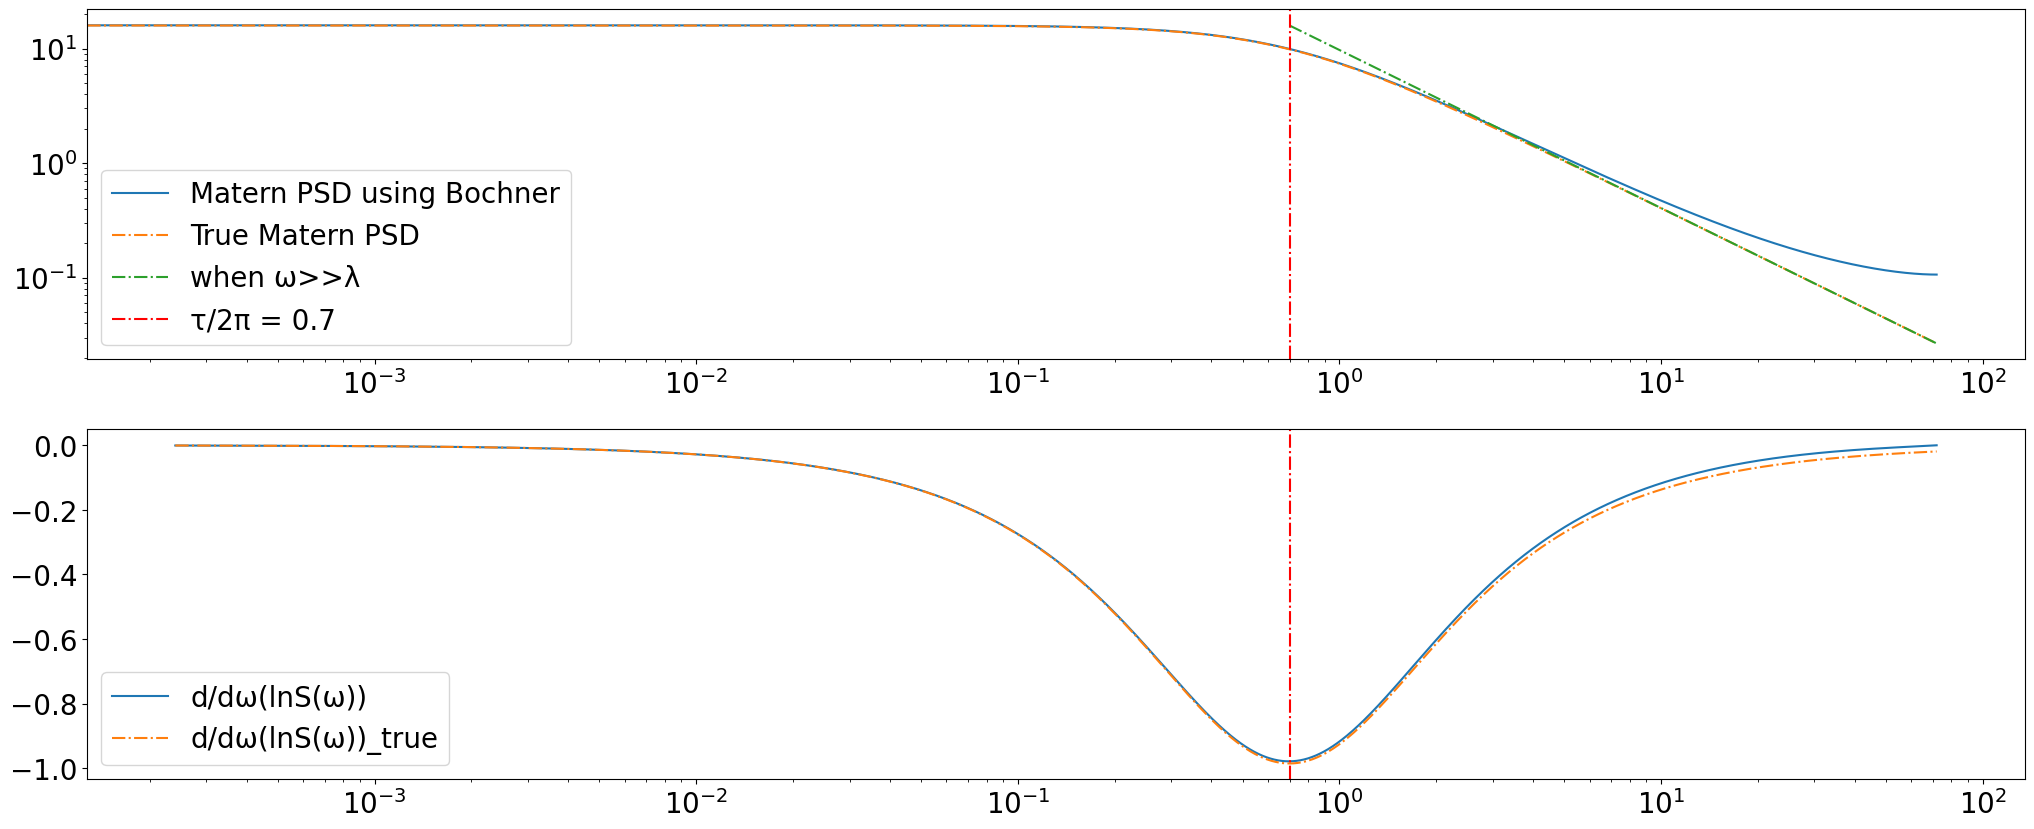

In [11]:
covparams = [8.53484804, 0.68951837]
λ_test = 0.7
#ACF
acf_Matern1 = matern(tt, covparams,lmbda=λ_test)
#estiamted using bochner from ACF
ff_Matern1, S_bias_Matern1 = gary.bochner(acf_Matern1, delta, bias=True)
S_M_Amp = Asymptote_Matern(ff_Matern1, covparams , lmbda=λ_test)
#True PSD
S_true = matern_spectra(ff_Matern1, covparams , lmbda=λ_test)
#1st Derivative (numerically)
x = ff_Matern1
y = S_bias_Matern1
dydx = np.gradient(y, x)/y #the logarithm of the spectrum
dydx_true = Matern_PSD_1st_derivative_true(x,covparams,lmbda=λ_test)
# plt.plot(ff_Matern1[ff_Matern1>=0], S_bias_Matern1[ff_Matern1>=0], label="1")
#
plt.subplot(2,1,1)
plt.plot(ff_Matern1[ff_Matern1>=0], S_bias_Matern1[ff_Matern1>=0], label='Matern PSD using Bochner')
plt.plot(ff_Matern1[ff_Matern1>=0], S_true[ff_Matern1>=0],'-.', label="True Matern PSD")
plt.plot(ff_Matern1[ff_Matern1>=λ_test], S_M_Amp[ff_Matern1>=λ_test],'-.', label="when ω>>λ")
plt.axvline(x=λ_test,linestyle='-.',color='r',label = 'τ/2π = {}'.format(λ_test))
plt.legend()
# plt.xlim(0,10)
plt.xscale('log')
plt.yscale('log')

plt.subplot(2,1,2)
plt.plot(x[x>0],dydx[x>0],label='d/dω(lnS(ω))')
plt.plot(x[x>0],dydx_true[x>0],'-.',label='d/dω(lnS(ω))_true')
plt.legend()
plt.axvline(x=λ_test,linestyle='-.',color='r',label = 'τ/2π = {}'.format(λ_test))
# plt.xlim(0,10)
plt.xscale('log')
# plt.yscale('log')
print('the breaking point is at',10/2/np.pi)

## LR

In [13]:
#def psd
def LR_spectra(f, params, l_cos=2):
    eta, l_exp = params
    ω_0 = 2*np.pi*l_cos   #freq
    c = 1/l_exp   #freq = 1/period
    return np.power(eta, 2.)*c*(1/((2*np.pi*f-ω_0)**2 + c**2)+1/((2*np.pi*f+ω_0)**2 + c**2))
#define acf
def LR(dx,params,l_cos=2):
    '''
    l_cos: peak location (cpd)
    l_exp: peak broadening (day)
    '''    
    eta   = params[0]
    l_exp = params[1]   # day
    #convert unit
    ω_0 = 2*np.pi*l_cos   # radius
    c   = 1/l_exp   # r
    
    LR_cos = np.cos(dx*ω_0)
    LR_exp = np.exp(-np.abs(dx)*c)
    
    return np.power(eta,2.)*LR_cos*LR_exp

def LR_2(dx,params,l_cos=2):
    '''
    l_cos: peak location (cpd)
    l_exp: peak broadening (day)
    '''    
    eta   = params[0]
    l_exp = params[1]   # day
    gamma = params[2]
    #convert unit
    ω_0 = 2*np.pi*l_cos   # radius
    c   = 1/l_exp   # r
    LR_cos = np.cos(dx*ω_0)
    LR_exp = np.exp(-np.power(np.abs(dx)*c,gamma))
    return np.power(eta,2.)*LR_cos*LR_exp

Text(0.5, 1.0, 'Synthetic data with decorrelation of τ_L = 4 days')

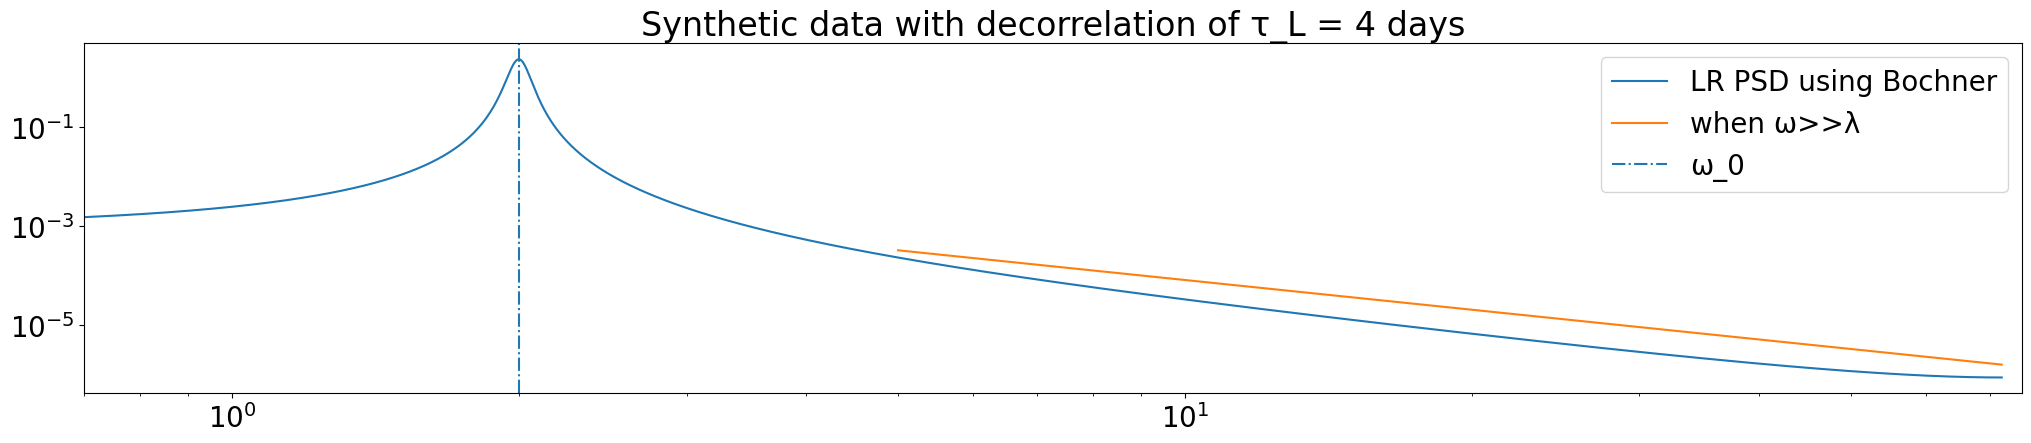

In [14]:
from functions import Cov
n = 600000
delta = 600/86400
tt = ut.taus(n, delta)
covparams = [0.8 ,4,1.2]
plt.subplot(211)
#ACF
acf_LR2 = LR_2(tt, covparams,l_cos=2)
#estiamted using bochner from ACF
ff_LR2, S_bias_LR2 = gary.bochner(acf_LR2, delta, bias=True)
#True PSD
# S_true = LR_spectra(ff_LR2, covparams, l_cos=2)
S_L_Amp = Asymptote_LR(ff_LR2[ff_LR2>=5], covparams)
plt.rcParams['figure.figsize'] = [25, 20]
plt.plot(ff_LR2[ff_LR2>=0], S_bias_LR2[ff_LR2>=0], label='LR PSD using Bochner')
# plt.plot(ff_LR2[ff_LR2>=0], S_true[ff_LR2>=0],'-.', label="True LR PSD")
plt.plot(ff_LR2[ff_LR2>=5],S_L_Amp,label="when ω>>λ")
plt.axvline(x=2,linestyle='-.',label = 'ω_0')
plt.legend()
plt.xlim(0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Synthetic data with decorrelation of τ_L = {} days'.format(covparams[1]))

# plt.subplot(212)
# tt_acf,acf_LR2_inv = gary.inv_bochner(LR_spectra,covparams,n,delta)
# plt.plot(tt[:5000],acf_LR2[:5000], label="True LR acf",)
# plt.plot(tt_acf[:5000],acf_LR2_inv[:5000],'-.',label='LR acf using bochner')
# plt.axvline(x=covparams[1],label = 'decorrelation',color='r')
# plt.legend()

In [15]:
# tt_acf,acf_LR2_ = gary.inv_bochner(LR_spectra,covparams,n,delta)
# plt.plot(tt_acf[:5000],acf_LR2_[:5000])
# plt.axvline(x=covparams[1]/2/np.pi,label = 'decorrelation',color='r')
# plt.legend()

## M1L2

In [17]:
def M1L2_spectra(f, params):
    noise = params[0]
    params_matern1 = params[1:3]
    params_LR1 = params[3:5]
    params_LR2 = params[5:7]
    return matern_spectra(f, params_matern1, lmbda=20) + LR_spectra(
        f, params_LR1,
        ℓ_cos1=1) + LR_spectra(f, params_LR2, ℓ_cos1=0.5) + np.power(
            np.abs(noise), 2)  #starts decay at semidiurnal peak

#define acf

def white_noise(dx,var):
    return var*scipy.signal.unit_impulse(len(dx)) #delta function


def M1L2(dx,params):
    
    O1_freq = 0.93 #cpd
    K1_freq = 1 #cpd
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = LR(dx,(eta1,ℓ_exp1),l_cos=(O1_freq+K1_freq)/2)
    peak2 = LR(dx,(eta2,ℓ_exp2),l_cos=(S2_freq+M2_freq)/2)
    COV = matern1 + peak1 + peak2 
    return COV

In [18]:
def M1L2_2(dx,params):
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd

    η_matern1 = params[0]
    α_matern1 = params[1]
    eta_S2    = params[2]
    tau_S2    = params[3]
    gamma_S2  = params[4]
    eta_M2    = params[5]
    tau_M2    = params[6]
    gamma_M2  = params[7]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak2   = LR_2(dx, (eta_S2,tau_S2,gamma_S2),l_cos=S2_freq) + LR_2(dx, (eta_M2,tau_M2,gamma_M2),l_cos=M2_freq)
    COV = matern1 + peak2 #+ noise
    return COV

def LR_2(dx,params,l_cos=2):
    '''
    l_cos: peak location (cpd)
    l_exp: peak broadening (day)
    '''    
    eta   = params[0]
    l_exp = params[1]   # day
    gamma = params[2]
    #convert unit
    ω_0 = 2*np.pi*l_cos   # radius
    c   = 1/l_exp   # r
    LR_cos = np.cos(dx*ω_0)
    LR_exp = np.exp(-np.power(np.abs(dx)*c,gamma))
    return np.power(eta,2.)*LR_cos*LR_exp

def M1P1(dx,params):
    D2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
    D2_freq = (D2_freq+M2_freq)/2
    
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta_D2    = params[2]
    tau_D2    = params[3]
    gamma_D2  = params[4]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak2   = Cov.LR_2(dx, (eta_D2,tau_D2,gamma_D2),l_cos=D2_freq) 
    COV = matern1 + peak2 #+ noise
    return COV

In [19]:
##bounds
bound_noise = [0,1]
bound_η_matern = [0.01,2]
bound_α_matern = [0.01,3.5] #impact the slope                  # from matern 7/2 to matern 1/2 to matern 0

# K1_freq,O1_freq,M2_freq,S2_freq
bound_eta = [0.01,1]     # K1 peak
bound_ℓ_exp = [0.01,40]  #impact how wide the brodening of peak 1 is (reverse proportional)  peak 1 is designed to be broader than peak 2

In [20]:
covparams = [0.3,1,0.5,6,1.5]

S2_freq = 1.93 #cpd
M2_freq = 2 #cpd
λ = 3
#analyticly define the acf
acf_true_M1L2 = M1P1(tt, covparams)
#acf_true_LR1 = LR(tt, covparams[2:],l_cos=(O1_freq+K1_freq)/2)
acf_true_LR2 = LR_2(tt, covparams[2:],l_cos=(S2_freq+M2_freq)/2)
#acf_true_LR2 = LR_2(tt, covparams[2:],l_cos=S2_freq) + LR_2(tt, covparams[5:],l_cos=M2_freq)
acf_true_Matern = matern(tt, covparams,lmbda=λ)

#numerically calculate spectrum from acf
ff_M1L2, S_bias_M1L2 = gary.bochner(acf_true_M1L2, delta, bias=True)
#ff_LR1, S_bias_LR1 = gary.bochner(acf_true_LR1, delta, bias=True)
ff_LR2, S_bias_LR2 = gary.bochner(acf_true_LR2, delta, bias=True)
ff_Matern, S_bias_Matern = gary.bochner(acf_true_Matern, delta, bias=True)

S_M_Amp =  Asymptote_Matern(ff_M1L2, covparams, lmbda=λ)
#S_L1_Amp = Asymptote_LR(ff_M1L2, covparams[2:])
S_L2_Amp = Asymptote_LR(ff_M1L2, covparams[2:])

C:\Users\21924032\AppData\Local\Temp\ipykernel_42184\466346793.py:14: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))
C:\Users\21924032\AppData\Local\Temp\ipykernel_42184\1815286008.py:12: RuntimeWarning: divide by zero encountered in power
  S *= np.power(np.power(ff, 2), -alpha)
C:\Users\21924032\AppData\Local\Temp\ipykernel_42184\1815286008.py:22: RuntimeWarning: divide by zero encountered in divide
  return np.power(eta, 2.)*c*2/(f**2 )


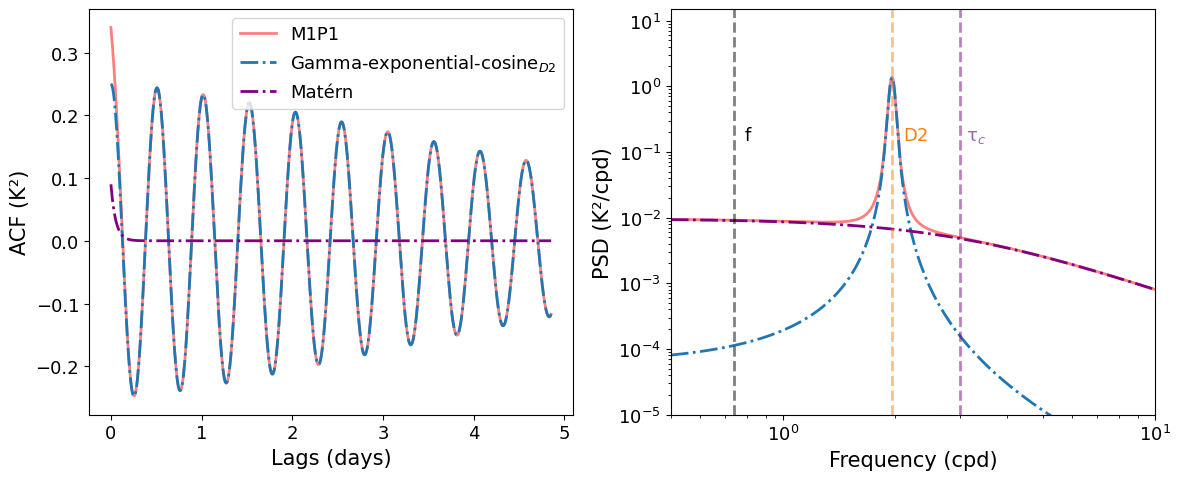

In [105]:
plt.rcParams['font.size'] =13
plt.rcParams['figure.figsize'] = [12,5]
plt.rcParams['lines.linewidth'] = 2
plt.subplot(122)

# plt.plot(ff_LR1[ff_LR1>=0], S_bias_LR1[ff_LR1>=0], label="LR1", linestyle="-.") 
plt.plot(ff_M1L2[ff_M1L2>=0], S_bias_M1L2[ff_M1L2>=0], label="M1P1",color='red',alpha=0.5) 
plt.plot(ff_LR2[ff_LR2>=0], S_bias_LR2[ff_LR2>=0], label="Gamma-exponential-cosine$_{D2}$", linestyle="-.") 
plt.plot(ff_Matern[ff_Matern>=0], S_bias_Matern[ff_Matern>=0], label="Matérn", linestyle="-.",color='purple') 
plt.axvline(x=f_coriolis_cpd, color='black',linestyle='--', alpha = 0.5)
# plt.axvline(x=0.965, color='tab:blue', linestyle='--', alpha = 0.5)
plt.axvline(x=1.965, color='tab:orange', linestyle='--', alpha = 0.5)
plt.axvline(x=3, color='purple',linestyle='--', alpha = 0.5)
plt.text(f_coriolis_cpd+0.05, 0.15, 'f', color='black', )
# plt.text(1+0.1, 0.15, 'D1', color='tab:blue', )
plt.text(2+0.1, 0.15, 'D2', color='tab:orange', )
plt.text(3+0.1, 0.15, 'τ$_{c}$', color='tab:purple', )
plt.xlim(0.5,10)
plt.ylim(1e-5,15)
plt.ylabel("PSD (K²/cpd)",fontsize=15)
plt.xlabel("Frequency (cpd)",fontsize=15)
plt.yscale('log')
plt.xscale('log')


plt.subplot(121)
plt.plot(tt[:700], acf_true_M1L2[:700], label="M1P1",color='red',alpha=0.5)#, linestyle="dashed")
plt.plot(tt[:700], acf_true_LR2[:700], label="Gamma-exponential-cosine$_{D2}$", linestyle="-.")
plt.plot(tt[:700], acf_true_Matern[:700], label="Matérn", linestyle="-.",color='purple')
# plt.title('Analytic True')
plt.ylabel("ACF (K²)",fontsize=15)
plt.xlabel("Lags (days)",fontsize=15)
plt.legend() 
plt.tight_layout()
plt.savefig('cov figure.pdf', bbox_inches='tight')

In [40]:
covparams = [0.1,1,1,160,1,30]
λ = 3
#analyticly define the acf
acf_true_LR1 = LR(tt, covparams[2:],l_cos=(O1_freq+K1_freq)/2)
acf_true_LR2 = LR(tt, covparams[4:],l_cos=(O1_freq+K1_freq)/2)

#numerically calculate spectrum from acf
ff_M1L2, S_bias_M1L2 = gary.bochner(acf_true_M1L2, delta, bias=True)
ff_LR1, S_bias_LR1 = gary.bochner(acf_true_LR1, delta, bias=True)
ff_LR2, S_bias_LR2 = gary.bochner(acf_true_LR2, delta, bias=True)
ff_Matern, S_bias_Matern = gary.bochner(acf_true_Matern, delta, bias=True)

S_M_Amp =  Asymptote_Matern(ff_M1L2, covparams, lmbda=λ)
S_L1_Amp = Asymptote_LR(ff_M1L2, covparams[2:])
S_L2_Amp = Asymptote_LR(ff_M1L2, covparams[4:])

plt.rcParams['font.size'] = 30
plt.subplot(122)

plt.plot(ff_LR1[ff_LR1>=0], S_bias_LR1[ff_LR1>=0], label="LR1", linestyle="-.") 
plt.plot(ff_LR2[ff_LR2>=0], S_bias_LR2[ff_LR2>=0], label="LR2", linestyle="-.") 

# plt.plot(ff_M1L2[ff_M1L2>=5],S_L1_Amp[ff_M1L2>=5],label='L1_asymptote')
# plt.plot(ff_M1L2[ff_M1L2>=5],S_L2_Amp[ff_M1L2>=5],label='L2_asymptote')
plt.axvline(x=f_coriolis_cpd, color='tab:green',linestyle='--', alpha = 0.5)
plt.axvline(x=0.965, color='tab:blue', linestyle='--', alpha = 0.5)
plt.axvline(x=1.965, color='tab:orange', linestyle='--', alpha = 0.5)

plt.text(f_coriolis_cpd, 1.5, 'f', color='tab:green', )
plt.text(1, 1.5, 'D1', color='tab:blue', )
plt.text(2, 1.5, 'D2', color='tab:orange', )
plt.xlim(0.2,35)
plt.ylabel("PSD (K²/cpd)")
plt.xlabel("Frequency (cpd)")
plt.yscale('log')
plt.xscale('log')
# plt.legend(fontsize = 20)

plt.subplot(121)

plt.plot(tt[:2000], acf_true_LR1[:2000], label="LR1", linestyle="-.")
plt.plot(tt[:2000], acf_true_LR2[:2000], label="LR2", linestyle="-.")

# plt.title('Analytic True')
plt.ylabel("ACF (K)")
plt.xlabel("Lags (days)")
plt.legend(fontsize = 20)
plt.tight_layout()

NameError: name 'O1_freq' is not defined

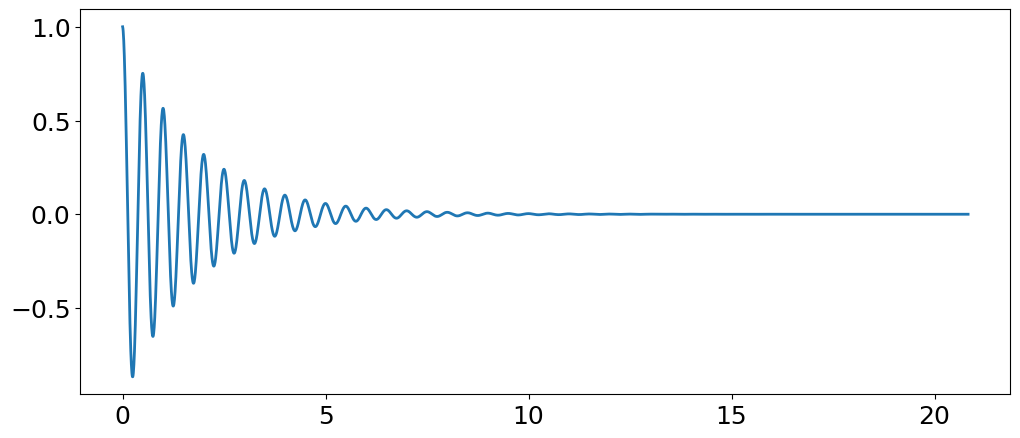

In [43]:
plt.plot(tt[:3000], np.cos(2*np.pi*2*tt[:3000])*np.exp(-tt[:3000]*2*np.pi/11), label="LR1")

## GP sample

In [63]:
def LR_GP(x,xpr,params,l_cos=2):
    '''
    l_cos: peak location (cpd)
    l_exp: peak broadening (day)
    '''    
    dx = np.abs(x-xpr)
    eta   = params[0]
    l_exp = params[1]   # day
    #convert unit
    ω_0 = 2*np.pi*l_cos   # radius
    c   = 2*np.pi/l_exp   # radius^-1
    
    LR_cos = np.cos(dx*ω_0)
    LR_exp = np.exp(-np.abs(dx)*c)
    
    return np.power(eta,2.)*LR_cos*LR_exp

def matern_GP(x,xpr, params,lmbda=3, sigma = 0, acf = True):
    """General Matern covariance a la Lilly/Sykulski"""
    dx = np.abs(x-xpr)
    eta = params[0]
    alpha = params[1]
#     lmbda = params[2]   # cpd

    lmbda = 2*np.pi*lmbda  #radius
    nu = alpha - 1/2
    
    K = 2 * np.power(eta, 2) / (gamma(nu) * np.power(2, nu))
    K *= np.power(np.abs(lmbda * dx), nu)
    K *= K_nu(nu, np.abs(lmbda * dx))
    K[np.isnan(K)] = np.power(eta, 2.)

    if acf:
        K[0] = K[0] + sigma**2
    else:
        n = dx.shape[0]
        K += sigma**2 * np.eye(n)
    return K

def M1L2_GP(x,xpr,params):
    dx = np.abs(x-xpr)
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = LR(dx,(eta1,ℓ_exp1),l_cos=1)
    peak2 = LR(dx,(eta2,ℓ_exp2),l_cos=2)
#     noise = white_noise(dx,noise_var)'
    COV = matern1 + peak1 + peak2 
    return COV

In [64]:
# Input data points
N = 500
dx = 600/86400
xd = np.arange(0,dx*N,dx)[:,None]
noise = 0

GP_matern = GPtideScipy(xd, xd, noise, matern_GP, covparams).prior(samples=1)
GP_LR1   = GPtideScipy(xd, xd, noise, LR_GP, covparams[2:]).prior(samples=1)
GP_LR2   = GPtideScipy(xd, xd, noise, LR_GP, covparams[4:]).prior(samples=1)
GP_M1L2  = GPtideScipy(xd, xd, noise, M1L2_GP, covparams).prior(samples=1)

C:\Users\21924032\AppData\Local\Temp\ipykernel_22004\2331270097.py:30: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))
C:\Users\21924032\AppData\Local\Temp\ipykernel_22004\466346793.py:14: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


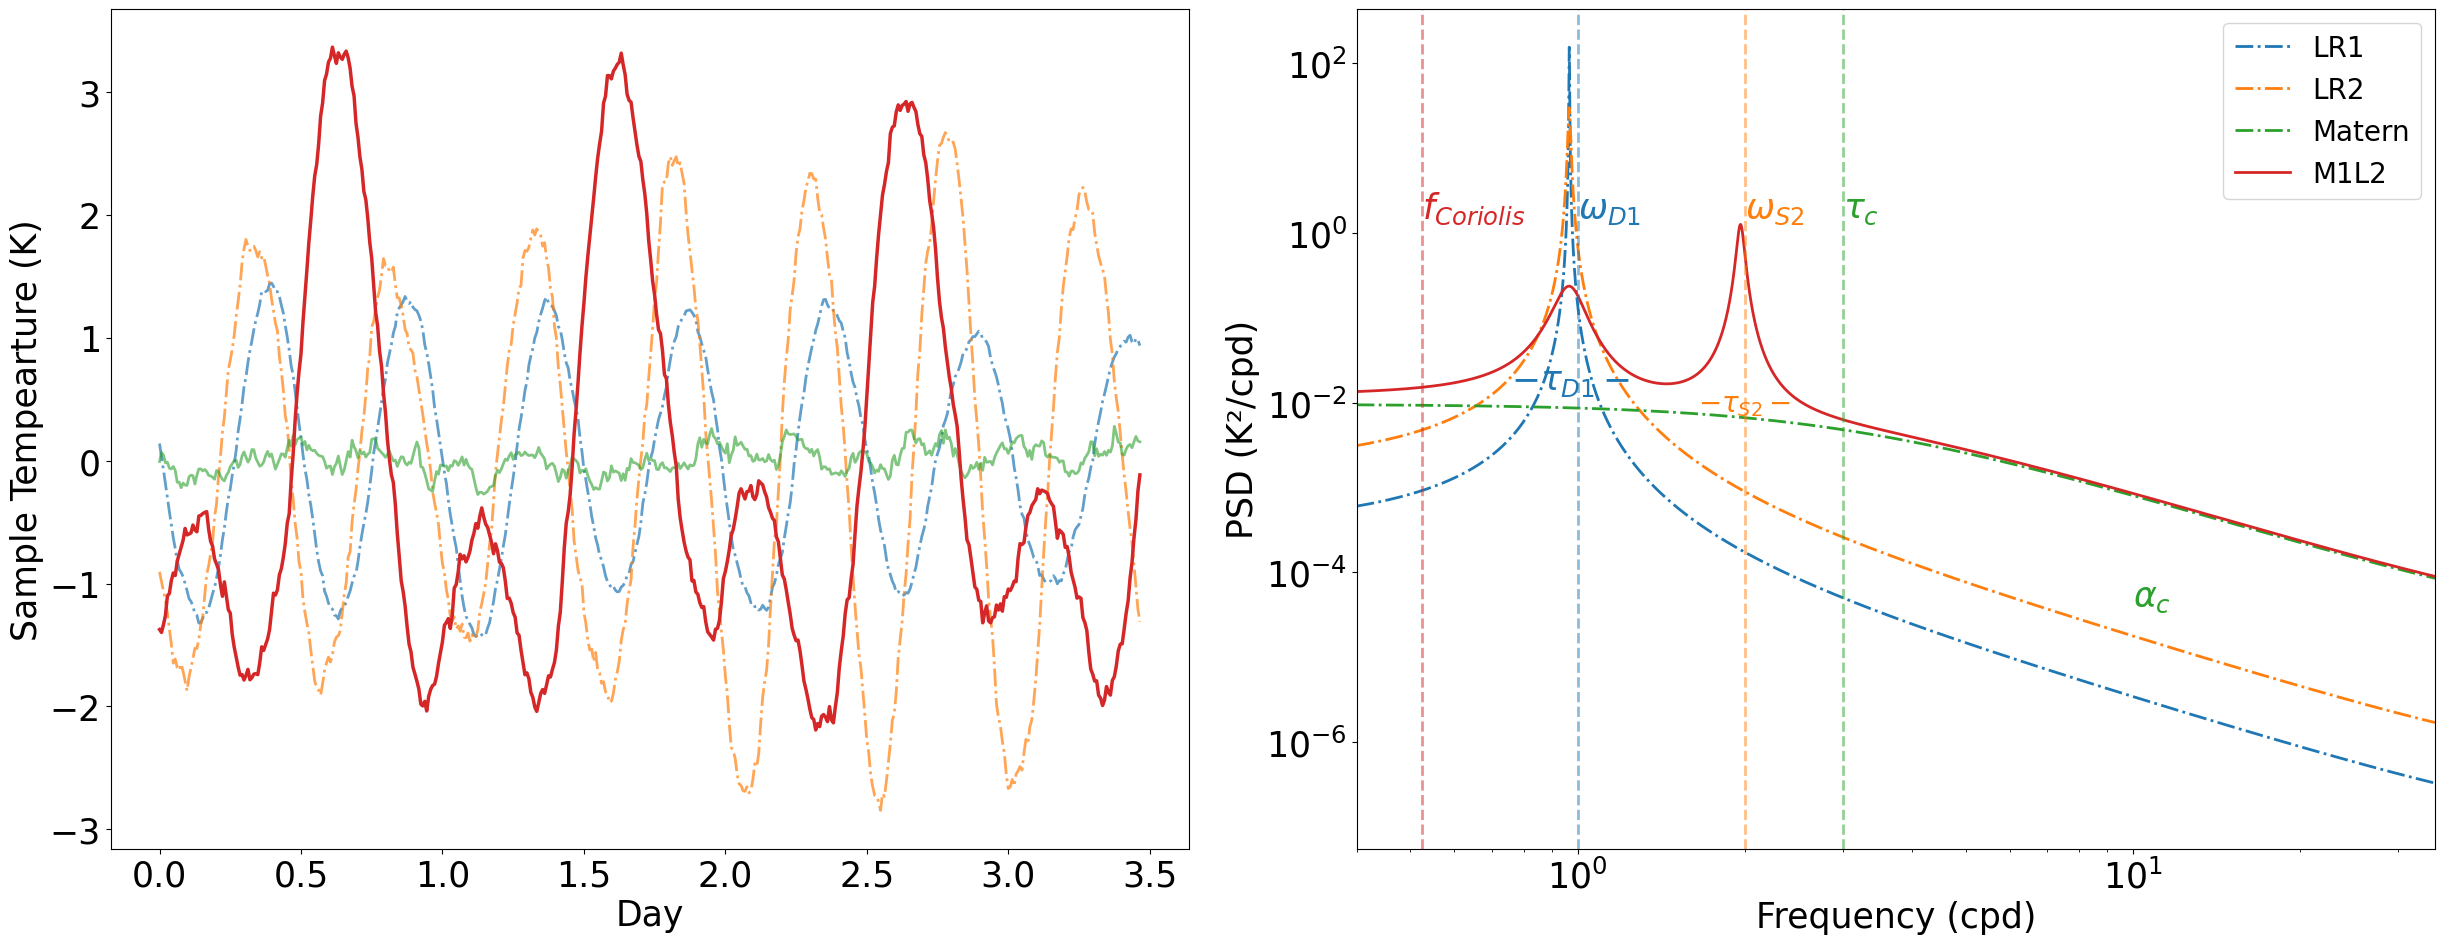

In [71]:
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [25, 10]
plt.subplot(122)
plt.plot(ff_LR1[ff_LR1>=0], S_bias_LR1[ff_LR1>=0], label="LR1", linestyle="-.") 
plt.plot(ff_LR2[ff_LR2>=0], S_bias_LR2[ff_LR2>=0], label="LR2", linestyle="-.") 
plt.plot(ff_Matern[ff_Matern>=0], S_bias_Matern[ff_Matern>=0], label="Matern",linestyle="-.") 
plt.plot(ff_M1L2[ff_M1L2>=0], S_bias_M1L2[ff_M1L2>=0], label="M1L2") 
# plt.plot(ff_M1L2[ff_M1L2>=10],S_M_Amp[ff_M1L2>=10],color = 'tab:green',label='M_asymptote')
plt.axvline(x=f_coriolis_cpd, color='tab:red', linestyle='--', alpha = 0.5)
plt.axvline(x=1, color='tab:blue', linestyle='--', alpha = 0.5)
plt.axvline(x=2, color='tab:orange', linestyle='--', alpha = 0.5)
plt.axvline(x=3, color='tab:green', linestyle='--', alpha = 0.5)

plt.text(f_coriolis_cpd, 1.5, '$f_{Coriolis}$', color='tab:red', fontsize=25)
plt.text(1, 1.5, '$\omega_{D1}$', color='tab:blue', fontsize=25)

plt.text(0.76, 0.014, '$-τ_{D1}-$', color='tab:blue', fontsize=25)
plt.text(2, 1.5, '$\omega_{S2}$', color='tab:orange', fontsize=25)
plt.text(1.65, 0.008, '$-τ_{S2}-$', color='tab:orange', fontsize=20)
plt.text(3, 1.5, '$τ_{c}$', color='tab:green', fontsize=25)
plt.text(10, 0.00004, '$α_{c}$', color='tab:green', fontsize=25)

# plt.text(0.45,0.0035, '$\eta_{D1}$', color='tab:blue', fontsize=25)
# plt.text(0.45,0.0014, '$\eta_{c}$', color='tab:green', fontsize=25)
# plt.text(0.45,0.0004, '$\eta_{S2}$', color='tab:orange', fontsize=25)

plt.xlim(0.4,35)
plt.ylabel("PSD (K²/cpd)")
plt.xlabel("Frequency (cpd)")
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize = 20)

plt.subplot(121)
#PLOT
plt.plot(xd,GP_LR1,label="LR1", linestyle="-.",alpha=0.7)
plt.plot(xd,GP_LR2, label="LR2", linestyle="-.",alpha=0.7)
plt.plot(xd,GP_matern,label='Matern',alpha=0.6)
plt.plot(xd,GP_M1L2 ,label='M1L2',color='tab:red',linewidth=2.5)
# plt.legend(fontsize = 20)
plt.xlabel("Day")
plt.ylabel("Sample Tempearture (K)")
plt.tight_layout()

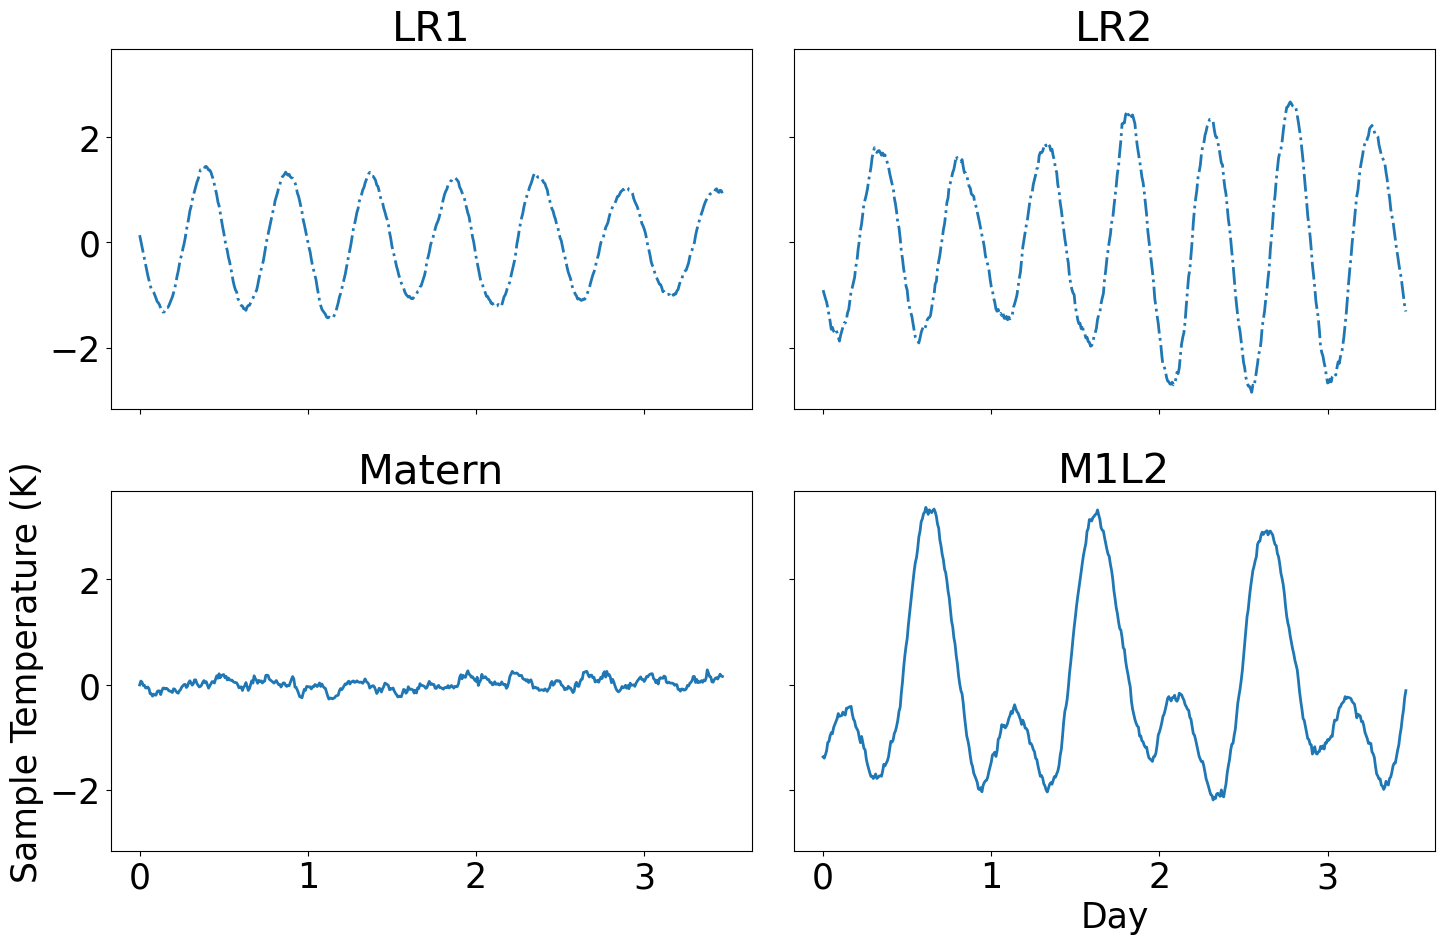

In [73]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10),sharex='all',sharey='all')

# Plot in each subplot
axs[0, 0].plot(xd, GP_LR1, label="LR1", linestyle="-.")
axs[0, 0].set_title("LR1")
axs[0, 1].plot(xd, GP_LR2, label="LR2", linestyle="-.")
axs[0, 1].set_title("LR2")
axs[1, 0].plot(xd, GP_matern, label='Matern')
axs[1, 0].set_title("Matern")
axs[1, 1].set_xlabel("Day")
axs[1, 0].set_ylabel("Sample Temperature (K)")

axs[1, 1].plot(xd, GP_M1L2, label='M1L2')
axs[1, 1].set_title("M1L2")
axs[1, 1].set_xlabel("Day")


plt.tight_layout()

In [74]:
# from scipy.interpolate import CubicSpline
# n_interp = 100000
# delta_interp  = 60/86400
# tt_interp  = ut.taus(n_interp , delta_interp)
# cubic_interp_temp = CubicSpline(tt, gauss_sample)
# gauss_sample_interp = cubic_interp_temp(tt_interp)

In [ ]:
# plt.plot(tt, ra_sample,label='ra_sample')
# plt.plot(tt, gauss_sample,label='gauss_sample')
# plt.plot(tt_interp, gauss_sample_interp,label='gauss_sample_interp')
# plt.legend()

In [ ]:
# #analyticly define the acf
# acf_true = M1L2(tt_interp,covparams)
# #numerically calculate spectrum from acf
# ff_interp,S_bias_interp  = gary.bochner(acf_true, delta_interp, bias = True)        
# # _, S_nobias = gary.bochner(acf_true, delta, bias = False)     

# # #analyticly define the spectrum
# S_true =  M1L2_spectra(ff, covparams)  
   
# # #numberical calcualte acf from spectrum
# _, acf_boch = gary.inv_bochner(M1L2_spectra, covparams, n_interp, delta_interp)#,alias=True, tol=1e-7)

In [ ]:
#I_w
# f1,p1 = gary.periodogram(gauss_sample,delta)
# f2,p2 = processing.welch(gauss_sample,delta,nperseg=2**12)
# f11,p11 = gary.periodogram(ra_sample,delta)
# f22,p22 = processing.welch(ra_sample,delta,nperseg=2**12)
# f1,p1 = gary.periodogram(gauss_sample_interp,delta_interp)
# f2,p2 = processing.welch(gauss_sample_interp,delta_interp,nperseg=2**12)

# f1_positive = f1[f1>=0]
# p1_positive = p1[f1>=0]

In [ ]:
# def subset(ff):
#     f_semidiurnal = 1
#     coriolis_peak_bandwidth = 0.1
#     M4_peak_bandwidth  = 0.1
#     M4_freq = 2*0.0805*24 #cpd
#     buoyancy_freq = 100
#     return np.logical_or(np.less(f_semidiurnal + coriolis_peak_bandwidth, ff) & np.less(ff, M4_freq-M4_peak_bandwidth), #omit M4 peak
#                   np.less(M4_freq + M4_peak_bandwidth, ff) & np.less(ff,buoyancy_freq)) 

In [ ]:
# #subset
# subset_p =subset(f1_positive) 
# subset_w =subset(f2)

# subset_p = np.array([True]*len(f1_positive))
# subset_w = np.array([True]*len(f2))

# subset_p = [f1_positive<30]
# subset_w = [f2<30]

In [ ]:
# plt.plot(f1_positive,p1_positive,label= 'synthetic sample periodogram')
# plt.plot(f1_positive[subset_p],p1_positive[subset_p],label= 'synthetic sample subset')
# # plt.plot(ff[ff>=0], S_true[ff>=0],label = 'analytic true')
# plt.plot(ff_interp,S_bias_interp,label = 'bochner',linestyle="dashed")
# plt.plot(ff[ff>=0], S_true[ff>=0],'.',label = 'analytic true')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-8, 50)
# # plt.xlim(-5,10)

In [ ]:
# covparams

# Fit

In [ ]:
#Initia guess
IG_noise = 1.5e-5

IG_η_matern = 0.5
IG_α_matern = 2 #impact the slope

IG_eta = 1
IG_ℓ_exp = 1 #impact how wide the brodening of peak 1 is (proportional)  

#bounds
bound_noise = [0,1]

bound_η_matern = [0.01,10]
bound_α_matern = [0.01,10] #impact the slope                  # from matern 7/2 to matern 1/2 to matern 0

# K1_freq,O1_freq,M2_freq,S2_freq
bound_eta = [0.01,10]     # K1 peak

bound_ℓ_exp = [0.01,10]  #impact how wide the brodening of peak 1 is (reverse proportional)  peak 1 is designed to be broader than peak 2

In [ ]:
#One_matern_One_LR_spectra

#Initia guess
M1L2_covparams_ic = [
                    IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,
                    IG_eta,
                    IG_ℓ_exp,
]

#Boundary
M1L2_bounds_parameter = [
                    bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,
                    bound_eta,
                    bound_ℓ_exp
]

M1L2_parameter_name = [
                    'noise',
                    'η_matern1',
                    'α_matern1',
                    'eta1',
                    'ℓ_exp1',
                    'eta1',
                    'ℓ_exp1',
]

In [ ]:
F_list,P_list

In [ ]:
fig, axes = plt.subplots(len(P_list),1,figsize=(8, 10))

for i, ax in enumerate(axes):
    ax.plot(F_list[i],P_list[i],label='Obs at {}'.format(depths[i]))
    ax.plot(omg*86400, GM_spectrum/86400,label='GM')
    # Plot vertical lines for each frequency and add labels
    ax.axvline(x= f_coriolis_cpd , color='r', linestyle='--',alpha=0.5)
    ax.axvline(x= O1_freq, color='g', linestyle='--',alpha=0.5)
    ax.axvline(x= S2_freq, color='b', linestyle='--',alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #custime figure
    ax.legend()
    ax.set_ylim(1e-5,1)
    ax.set_xlim(1.5e-1,200)
    
# Add labels next to the lines and on the top of the lines
axes[0].text(f_coriolis_cpd, 1.5, 'f', color='r', )
axes[0].text(O1_freq, 1.5, 'D1', color='g', )
axes[0].text(S2_freq, 1.5, 'S2', color='b', )
axes[1].set_ylabel('K²/cycles per day')
axes[2].set_xlabel('cycles per day')
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()